In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


# Setting up & Loading Data

In [2]:
PATH_OF_DATA= '/content/gdrive/MyDrive/"Learning in the Deep"/Dataset/'
!ls {PATH_OF_DATA}

LICENSE.TXT		testBlended  trainBlended  val.xml
substancesAuthors.html	test.xml     train.xml


In [3]:
import os
import torch
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset
import matplotlib.pyplot as pyplot
import torchvision.transforms as T
import numpy as np
from torch.utils.data.dataloader import DataLoader

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
isDemo = False

In [4]:
class PbrDataset(Dataset):
  def __init__(self,path):
    self.dir = path
    self.image_names = os.listdir(path)
    self.num_images = len(self.image_names)
  
  def __len__(self):
    return self.num_images
  
  def __getitem__(self,idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    img_pth = os.path.join(self.dir,self.image_names[idx])
    i = 0
    while i<20:
      i+=1
      try:
        img = read_image(img_pth).float()/255.0
        break
      except:
        idx += 1
        img_pth = os.path.join(self.dir,self.image_names[idx])
        img = read_image(img_pth).float()/255.0
        break
    return img[:,:,0:288],img[:,:,288:288*2],img[:,:,288*2:288*3],img[:,:,288*3:288*4]

In [5]:
train_dataset = PbrDataset('/content/gdrive/MyDrive/Learning in the Deep/Dataset/trainBlended')
test_dataset = PbrDataset('/content/gdrive/MyDrive/Learning in the Deep/Dataset/testBlended')
img_type=['lit','normal','diffuse','roughness']

In [6]:
# data_loader = DataLoader(train_dataset,batch_size=2, num_workers=2)
# index = 0
# for i,x in enumerate(data_loader):
#   index=i
    
#   X = transforms.Grayscale()(img[2])
#   lit = transforms.Grayscale()(img[0])
#   print(X.shape,lit.shape)
  
#   X = torch.concat((X,lit),1)
#   print(X.shape,lit.shape)
#   # pyplot.axis('off')
  # pyplot.imshow(img[2][0].permute(1,2,0))
  # pyplot.show()
  # pyplot.axis('off')
  # pyplot.imshow(X[0],cmap='gray')
  # pyplot.show()
  # pyplot.axis('off')
  # pyplot.imshow(img[0][0].permute(1,2,0))
  # pyplot.show()
  # pyplot.axis('off')
  # pyplot.imshow(lit[0],cmap='gray')
  # pyplot.show()
  # break

#Training & Test Loop

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer,input_index,output_index,niters=-1,print_every=100):
    loss_array = []
    loss_avg = 0
    model.train()
    for iter,images in enumerate(dataloader):
        if input_index == 2:
          X = transforms.Grayscale()(images[input_index])
          lit = transforms.Grayscale()(images[0])
          X = torch.concat((X,lit),1)
        y = transforms.Grayscale()(images[output_index])        
        X, y = X.float().to(DEVICE), y.float().to(DEVICE)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        if iter % print_every == 0:
            print('iteration:',iter,'loss:',loss.item())
        loss.backward()
        loss_array.append(loss.item())
        optimizer.step()
        for img in images:
          del img
        del X
        del y
        if niters!=-1 and niters==iter:
          break
    print('Average Train Loss:'+str(np.array(loss_array).sum()/len(loss_array)))
    return loss_array


def test_loop(dataloader, model, loss_fn,input_index,output_index):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images in dataloader:
            if input_index == 2:
              X = transforms.Grayscale()(images[input_index])
              lit = transforms.Grayscale()(images[0])
              X = torch.concat((X,lit),1)
            y = transforms.Grayscale()(images[output_index])
            X, y = X.float().to(DEVICE), y.float().to(DEVICE)            
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            for img in images:
              del img
            del X
            del y
    test_loss /= len(dataloader)
    print('Average Test Loss:'+str(test_loss))
    return test_loss

In [8]:
def plot_training():
    pyplot.title('Training Loss')
    pyplot.plot(train_loss, label='train')
    # pyplot.xlabel('Iterations')
    pyplot.margins(0, 0)
    pyplot.rcParams.update({'font.size': 16})
    pyplot.tight_layout()
    pyplot.show()

# Plot test loss vs iteration, and show important params in title
def plot_test():
    pyplot.figure()
    pyplot.title('Test Loss')
    pyplot.plot(test_loss, label='avg test', linewidth=3, color='orange')
    # pyplot.xlabel('Epoch')
    pyplot.margins(0, 0)
    pyplot.rcParams.update({'font.size': 16})
    pyplot.tight_layout()
    pyplot.show()

# Model and parameters

In [33]:
from torchvision.models import resnet18
model = resnet18()
layer_list = list(model.children())[:8]

layer_list[0] = torch.nn.Conv2d(2, 64, kernel_size=5, stride=1, padding=(3, 3), bias=False)
layer_list[5][0].conv1 = torch.nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer_list[5][0].downsample[0] = torch.nn.Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
layer_list[6][0].conv1 = torch.nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer_list[6][0].downsample[0] = torch.nn.Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
layer_list[7][0].conv1 = torch.nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
layer_list[7][0].downsample[0] = torch.nn.Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)

layer_list.insert(-2,torch.nn.ConvTranspose2d(128, 128, kernel_size=5, stride=1,  bias=False))
layer_list.append(torch.nn.Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1), bias=False))
layer_list.append(torch.nn.BatchNorm2d(128))
layer_list.append(torch.nn.ReLU(True)) 
layer_list.append(torch.nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), bias=False))
layer_list.append(torch.nn.BatchNorm2d(64))
layer_list.append(torch.nn.ReLU(True))
layer_list.append(torch.nn.Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), bias=False))

layer_list.pop(3)

model = torch.nn.Sequential(*layer_list).to(DEVICE)

# test = torch.randn((1,2,288,288)).to(DEVICE)
# print()
# print(model(test).shape)

In [34]:
BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 1e-4
REG = 1e-1

optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=REG,amsgrad=True)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
train_dataloader = DataLoader(train_dataset,batch_size=BATCH_SIZE, num_workers=6)
test_dataloader = DataLoader(test_dataset,batch_size=1, shuffle=True)
loss_fn = torch.nn.MSELoss()


Epoch 1
-------------------------------
iteration: 0 loss: 0.6731922626495361
iteration: 50 loss: 0.04903491213917732
iteration: 100 loss: 0.07459866255521774
iteration: 150 loss: 0.06902620196342468
iteration: 200 loss: 0.041068192571401596
iteration: 250 loss: 0.0522746816277504
iteration: 300 loss: 0.08269532769918442
iteration: 350 loss: 0.043857086449861526
iteration: 400 loss: 0.02747906558215618
iteration: 450 loss: 0.043110836297273636
iteration: 500 loss: 0.1084696352481842
Average Train Loss:0.05964321857448407
Average Test Loss:0.048226489000842865
Epoch 2
-------------------------------
iteration: 0 loss: 0.05004249885678291
iteration: 50 loss: 0.0423479862511158
iteration: 100 loss: 0.05966666340827942
iteration: 150 loss: 0.06255213171243668
iteration: 200 loss: 0.04974275827407837
iteration: 250 loss: 0.060572534799575806
iteration: 300 loss: 0.0672973096370697
iteration: 350 loss: 0.050826601684093475
iteration: 400 loss: 0.016255682334303856
iteration: 450 loss: 0.0497

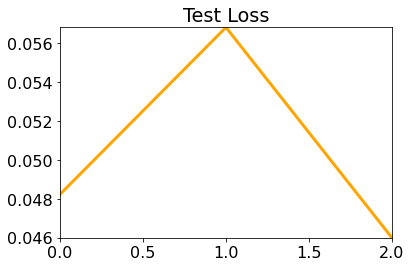

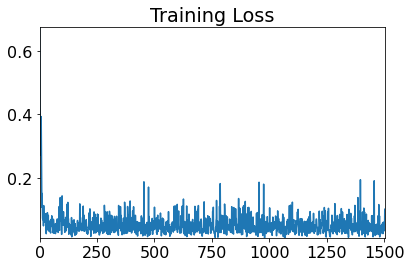

In [35]:
train_loss = []
train_loss_x = []
test_loss = []
test_loss_x = []

for t in range(EPOCHS):
  print(f"Epoch {t+1}\n-------------------------------")
  train_loss += train_loop(train_dataloader, model, loss_fn, optimizer,2,3,500,50)
  train_loss_x += np.linspace(float(t),float(t+1),len(train_loss)-len(train_loss_x)).tolist()
  test_loss.append(test_loop(test_dataloader, model, loss_fn,2,3))
  test_loss_x += [t+1] 
  optimizer.step()
plot_test()
plot_training()
torch.save(model,'/content/gdrive/MyDrive/Learning in the Deep/RoughnessModel.pth')

torch.Size([1, 2, 288, 288])


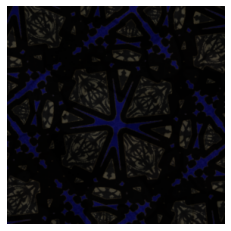

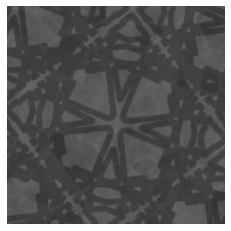

tensor(0.8123) tensor(0.3097)


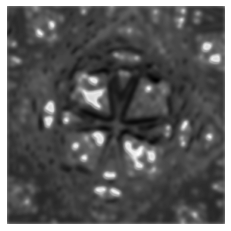

In [38]:
img = read_image('/content/gdrive/MyDrive/Learning in the Deep/testimg2.png').float()/255.0
diffuse = img[:,:,288*2:288*3]
diffuse = transforms.Grayscale()(diffuse)
lit = img[:,:,0:288]
lit = transforms.Grayscale()(lit)
diffuse = torch.concat((diffuse,lit),0).unsqueeze(0).to(DEVICE)
print(diffuse.shape)
pyplot.axis('off')
pyplot.imshow(img[:,:,288*2:288*3].permute(1,2,0))
pyplot.show() 
pyplot.axis('off')
pyplot.imshow(img[:,:,288*3:288*4].permute(1,2,0))
pyplot.show() 
model.eval()
with torch.no_grad():
  pred_roughness = model(diffuse).squeeze().squeeze().cpu() 
  print(torch.max(pred_roughness),torch.min(pred_roughness))
  pyplot.axis('off')
  pyplot.imshow(pred_roughness,cmap='gray')
  pyplot.show() 

In [32]:
with torch.no_grad():
  # del model
  torch.cuda.empty_cache()
import gc
gc.collect()

34